<AxesSubplot:>

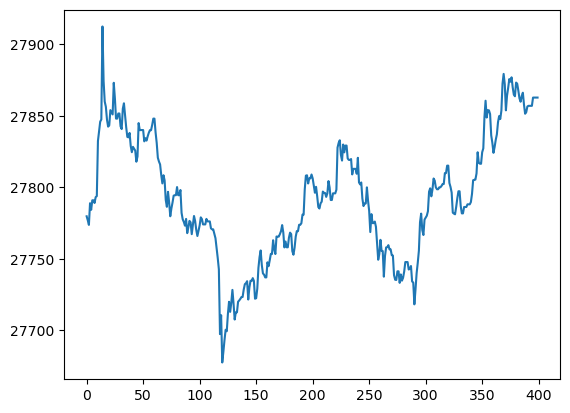

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.linalg import hankel
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
warnings.filterwarnings("ignore")
from scipy.stats import boxcox
from pandas import DataFrame
from SSA_class import SSA
from sklearn.model_selection import train_test_split 

################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
        plt.show()
    return

def split_dataframe_by_column(df, split_col, sort_col): 
    hash_map = {}
    for key in df[split_col].unique():
        hash_map[key] = df[df[split_col]==key].drop(split_col, axis=1).sort_values(by=[sort_col], ascending=True).reset_index(drop=True)
    return hash_map


aggregated_trade_volume_df = pd.read_csv("aggregated_trade_volume.csv")

trade_volume_map = split_dataframe_by_column(aggregated_trade_volume_df, 'currency', 'timestamp')
X = trade_volume_map['BTCUSDT']['cost'][600:][:400]
X.reset_index(drop=True, inplace=True)
X.plot()

In [2]:
mdl = smt.AutoReg(X,lags=30).fit()
print(mdl.params)

const       577.001458
cost.L1       1.035845
cost.L2      -0.051355
cost.L3      -0.041178
cost.L4       0.108639
cost.L5      -0.074648
cost.L6      -0.034595
cost.L7       0.051280
cost.L8       0.016741
cost.L9      -0.058672
cost.L10      0.045570
cost.L11     -0.002624
cost.L12      0.046506
cost.L13      0.022293
cost.L14     -0.101836
cost.L15     -0.010437
cost.L16      0.053753
cost.L17     -0.063548
cost.L18      0.087745
cost.L19     -0.035138
cost.L20     -0.054126
cost.L21      0.021713
cost.L22      0.045381
cost.L23      0.008321
cost.L24     -0.043691
cost.L25      0.020784
cost.L26      0.005131
cost.L27      0.022361
cost.L28      0.008051
cost.L29     -0.056556
cost.L30      0.007526
dtype: float64


<AxesSubplot:>

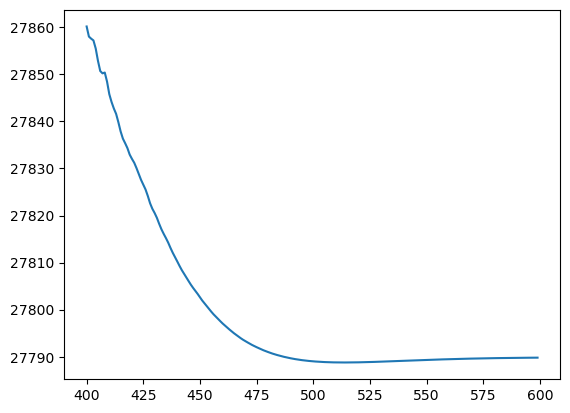

In [3]:
vc = mdl.forecast(200)
vc.plot()

Results of Dickey-Fuller Test:
Test Statistic                  -1.654172
p-value                          0.454866
#Lags Used                       0.000000
Number of Observations Used    399.000000
Critical Value (1%)             -3.446846
Critical Value (5%)             -2.868811
Critical Value (10%)            -2.570643
dtype: float64


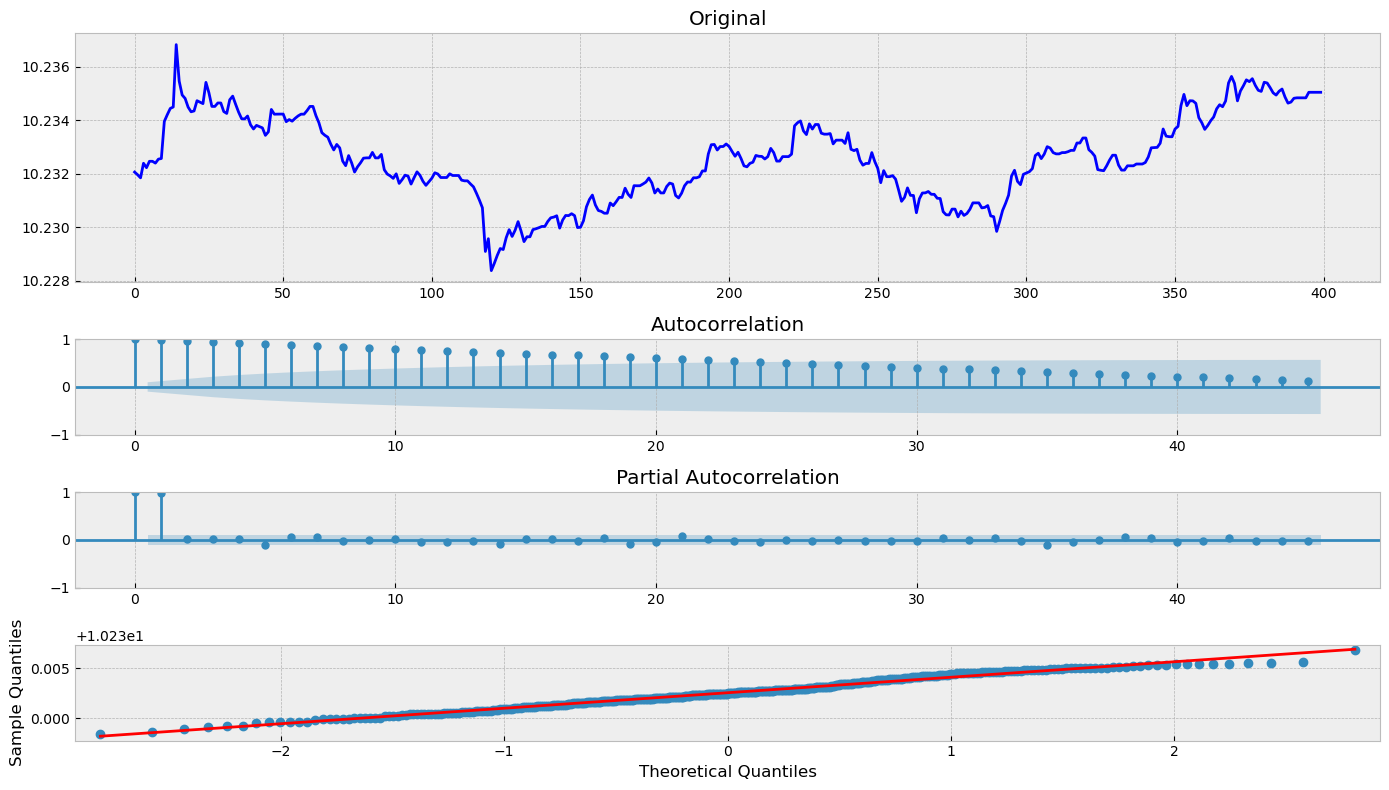

In [4]:
X = boxcox(X, 0)
tsplot(X, lags=45)

aic: -5331.31815 | order: (3, 0, 4)


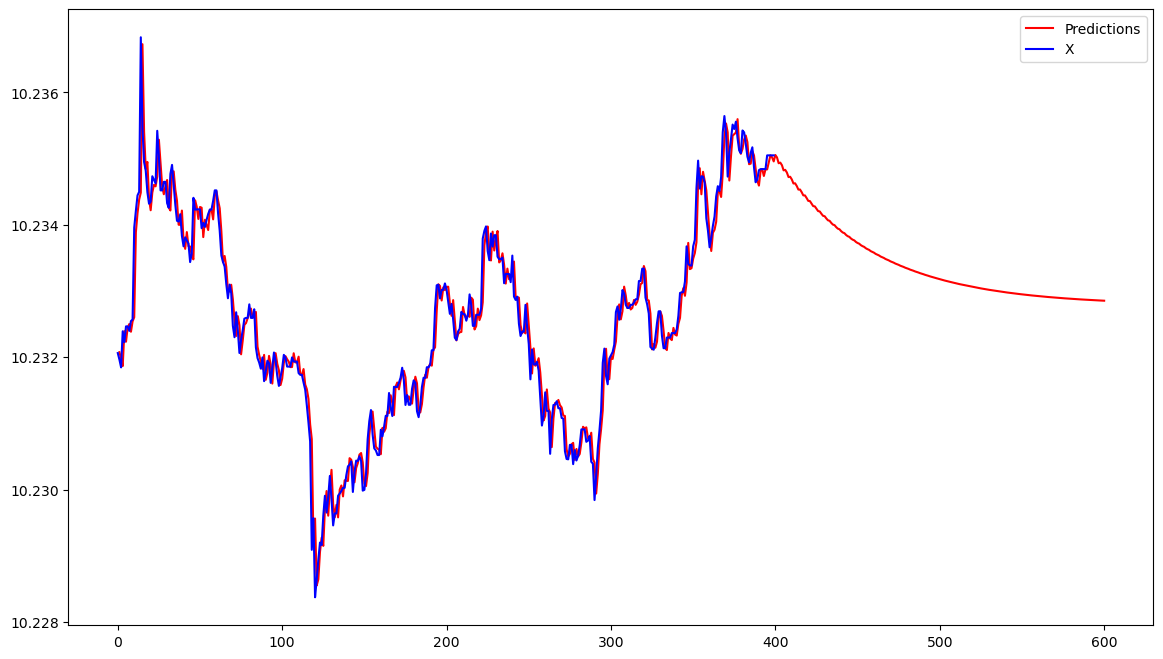

In [5]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(X, order=(i,d,j)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

 
plt.figure(figsize=(14,8))
ax = plt.axes()
predictions = best_mdl.predict(1, len(X)+200, ax=ax)
plt.plot(predictions, color='red', label='Predictions')
plt.plot(X, color='blue', label='X')
plt.legend()
plt.show()